<a href="https://colab.research.google.com/github/raghavmehta1/Accredian-backend-task/blob/master/Autism_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os as os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2. Remove Unwanted images

In [4]:
import cv2
import imghdr

In [5]:
!pip install kagglehub


In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
import kagglehub

# Download the dataset from Kaggle
path = kagglehub.dataset_download("cihan063/autism-image-data")


100%|██████████| 229M/229M [00:04<00:00, 49.6MB/s]

Extracting files...


In [8]:
data_dir = path
print("Path to dataset files:", data_dir)


Path to dataset files: /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1


In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Issue with image /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1/AutismDataset/consolidated
Issue with image /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1/AutismDataset/test
Issue with image /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1/AutismDataset/valid
Issue with image /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1/AutismDataset/train


In [10]:
os.listdir(data_dir)

['AutismDataset']

# 3. Load **Data**

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)


Found 5880 files belonging to 1 classes.


In [13]:
tf.keras.utils.image_dataset_from_directory??

In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

In [16]:
batch[0].shape

(32, 256, 256, 3)

In [17]:
#batch[1]

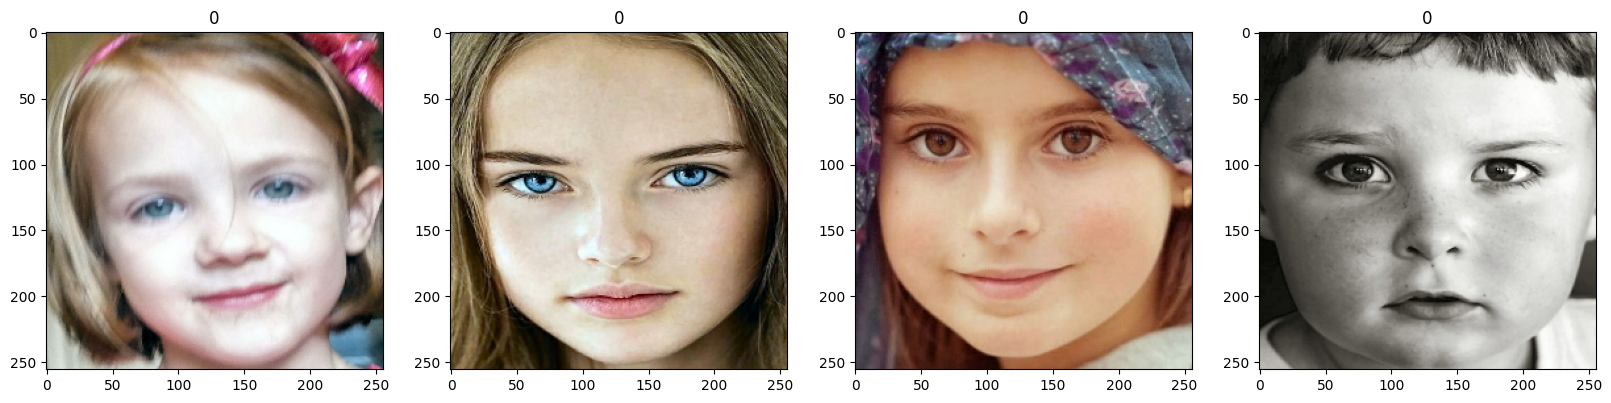

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [19]:
data = data.map(lambda x,y: (x/255, y))

In [20]:
data.as_numpy_iterator().next()

(array([[[[0.5529412 , 0.45115656, 0.30553   ],
          [0.55958945, 0.45780483, 0.3121783 ],
          [0.5724878 , 0.47070312, 0.32507658],
          ...,
          [0.69551045, 0.57389706, 0.3925092 ],
          [0.6997089 , 0.57858837, 0.39248234],
          [0.7060585 , 0.58841145, 0.39233303]],
 
         [[0.5524127 , 0.45437348, 0.29698223],
          [0.559061  , 0.46102175, 0.3036305 ],
          [0.57195926, 0.47392005, 0.3165288 ],
          ...,
          [0.7055377 , 0.58191633, 0.40105698],
          [0.7113894 , 0.5860371 , 0.40062058],
          [0.7113894 , 0.59268534, 0.3981924 ]],
 
         [[0.54725796, 0.45009956, 0.2866728 ],
          [0.55390626, 0.45674786, 0.29332107],
          [0.5668045 , 0.46964613, 0.30621937],
          ...,
          [0.7181357 , 0.58707106, 0.4096048 ],
          [0.7234644 , 0.59105766, 0.4102022 ],
          [0.7242111 , 0.59695923, 0.41352636]],
 
         ...,
 
         [[0.71284467, 0.4178462 , 0.2048024 ],
          [0.72281

In [21]:
batch[0].max()

255.0

In [22]:
len(data)

184

5. Split Data

In [23]:
train_size = int(len(data)*.75)+1
val_size = int(len(data)*.15)
test_size = int(len(data)*.1)

In [24]:
train_size+val_size+test_size

184

In [25]:
train_size

139

In [26]:
val_size

27

In [27]:
test_size

18

In [28]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

#6. Build Deep Learning Model

In [29]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create a Sequential model
model = Sequential()

# Define the input shape using an Input layer
model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adding Dropout for regularization
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

# Compile the model with 'learning_rate' instead of 'lr'
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Load your training and validation data using train_datagen

# Set up callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
# model.fit(train_data, validation_data=val_data, epochs=50, callbacks=[early_stop, reduce_lr])


In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 127, 127, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 30, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,697,905 (14.11 MB)

 Trainable params: 3,697,265 (14.10 MB)

 Non-trainable params: 640 (2.50 KB)

7. Train

In [32]:
logdir='logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
history = model.fit(
    train,
    epochs=5,
    validation_data=val,
    callbacks=[early_stop, reduce_lr])

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 139ms/step - accuracy: 0.6789 - loss: 0.6519 - val_accuracy: 1.0000 - val_loss: 0.0874 - learning_rate: 0.0010
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.9887 - loss: 0.0948 - val_accuracy: 1.0000 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9996 - loss: 0.0186 - val_accuracy: 1.0000 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 0.0010


8. Plot Performance

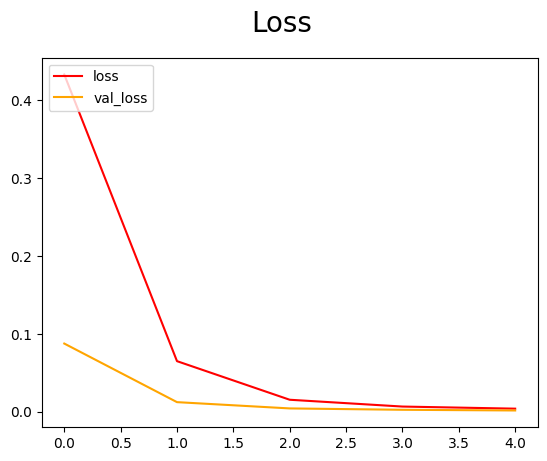

In [35]:
fig = plt.figure()
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

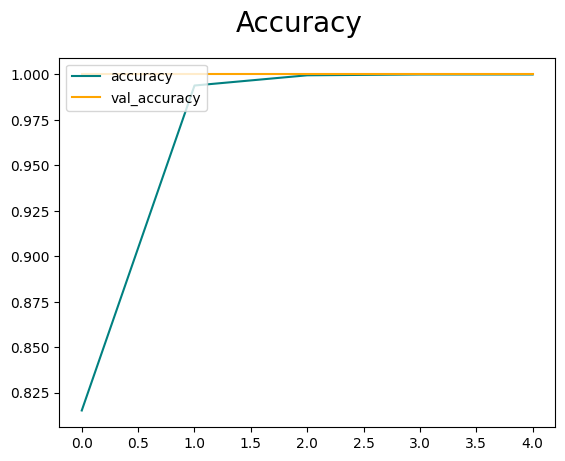

In [36]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator():
    X, y = batch
    z = model.predict(X)
    pre.update_state(y, z)
    re.update_state(y, z)
    acc.update_state(y, z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


In [40]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


10. Test

In [41]:
import cv2 as cv2

Dataset Path: /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1
Top-level files and folders in dataset: ['AutismDataset']
Files in the 'test' folder: ['Autistic.31.jpg', 'Non_Autistic.20.jpg', 'Non_Autistic.10.jpg', 'Autistic.65.jpg', 'Autistic.49.jpg', 'Autistic.63.jpg', 'Non_Autistic.117.jpg', 'Autistic.106.jpg', 'Autistic.112.jpg', 'Non_Autistic.94.jpg', 'Non_Autistic.32.jpg', 'Autistic.3.jpg', 'Autistic.92.jpg', 'Autistic.70.jpg', 'Non_Autistic.74.jpg', 'Autistic.45.jpg', 'Non_Autistic.48.jpg', 'Autistic.28.jpg', 'Autistic.74.jpg', 'Non_Autistic.131.jpg', 'Autistic.30.jpg', 'Non_Autistic.144.jpg', 'Autistic.16.jpg', 'Non_Autistic.13.jpg', 'Non_Autistic.58.jpg', 'Non_Autistic.40.jpg', 'Autistic.127.jpg', 'Autistic.21.jpg', 'Autistic.25.jpg', 'Autistic.148.jpg', 'Non_Autistic.64.jpg', 'Non_Autistic.22.jpg', 'Non_Autistic.149.jpg', 'Autistic.145.jpg', 'Non_Autistic.4.jpg', 'Non_Autistic.84.jpg', 'Autistic.34.jpg', 'Autistic.22.jpg', 'Autistic.29.jpg', 'Autistic.55.

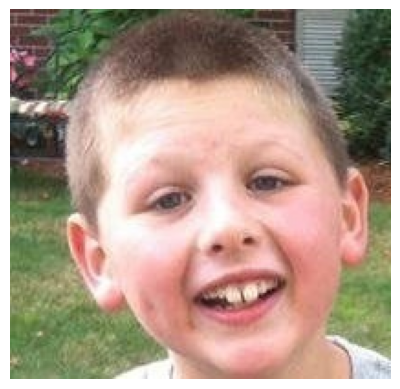

In [42]:
import kagglehub
import os
import cv2
import matplotlib.pyplot as plt

# Download the dataset from Kaggle and get the path
path = kagglehub.dataset_download("cihan063/autism-image-data")

# Print the dataset path and check the top-level structure
print("Dataset Path:", path)
print("Top-level files and folders in dataset:", os.listdir(path))  # List the contents

# Check the structure of the 'test' folder
test_dir = os.path.join(path, 'AutismDataset', 'test')
if os.path.exists(test_dir):
    print(f"Files in the 'test' folder: {os.listdir(test_dir)}")
else:
    print(f"'test' folder does not exist. Please check the directory structure.")

# Define the image path within the downloaded dataset
img_path = os.path.join(test_dir, "Autistic.134.jpg")

# Ensure the image exists at the specified path
if os.path.exists(img_path):
    # Read and display the image
    img = cv2.imread(img_path)  # Read image using OpenCV
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
else:
    print(f"Image {img_path} not found. Please verify the image name and path.")


print("Dataset Path:", path)


In [43]:
import os

# Get the path from Kaggle dataset
path = kagglehub.dataset_download("cihan063/autism-image-data")

# Print the dataset path to understand its structure
print("Dataset Path:", path)

# Check the contents at the root level of the dataset
root_contents = os.listdir(path)
print("Contents of the dataset:", root_contents)

# Check if 'AutismDataset' is a subfolder or not and locate the 'test' folder
if 'AutismDataset' in root_contents:
    sub_dir_path = os.path.join(path, 'AutismDataset', 'test')  # If 'AutismDataset' folder exists
else:
    sub_dir_path = os.path.join(path, 'test')  # If 'test' is directly in the root folder

# Print the contents of the 'test' folder
if os.path.exists(sub_dir_path):
    print("Contents of the 'test' folder:", os.listdir(sub_dir_path))
else:
    print(f"The 'test' folder was not found at {sub_dir_path}. Please verify the folder structure.")


Dataset Path: /root/.cache/kagglehub/datasets/cihan063/autism-image-data/versions/1
Contents of the dataset: ['AutismDataset']
Contents of the 'test' folder: ['Autistic.31.jpg', 'Non_Autistic.20.jpg', 'Non_Autistic.10.jpg', 'Autistic.65.jpg', 'Autistic.49.jpg', 'Autistic.63.jpg', 'Non_Autistic.117.jpg', 'Autistic.106.jpg', 'Autistic.112.jpg', 'Non_Autistic.94.jpg', 'Non_Autistic.32.jpg', 'Autistic.3.jpg', 'Autistic.92.jpg', 'Autistic.70.jpg', 'Non_Autistic.74.jpg', 'Autistic.45.jpg', 'Non_Autistic.48.jpg', 'Autistic.28.jpg', 'Autistic.74.jpg', 'Non_Autistic.131.jpg', 'Autistic.30.jpg', 'Non_Autistic.144.jpg', 'Autistic.16.jpg', 'Non_Autistic.13.jpg', 'Non_Autistic.58.jpg', 'Non_Autistic.40.jpg', 'Autistic.127.jpg', 'Autistic.21.jpg', 'Autistic.25.jpg', 'Autistic.148.jpg', 'Non_Autistic.64.jpg', 'Non_Autistic.22.jpg', 'Non_Autistic.149.jpg', 'Autistic.145.jpg', 'Non_Autistic.4.jpg', 'Non_Autistic.84.jpg', 'Autistic.34.jpg', 'Autistic.22.jpg', 'Autistic.29.jpg', 'Autistic.55.jpg', 'Non_A

In [44]:
!pip install opencv-python


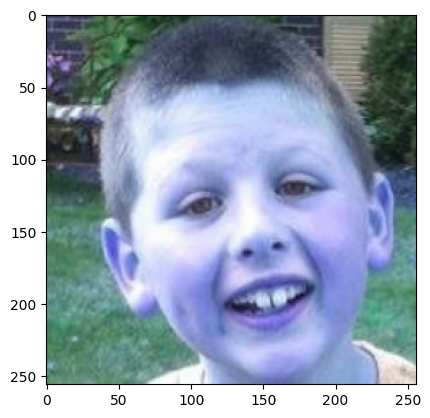

In [45]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
z= model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


In [47]:
z

array([[0.00040856]], dtype=float32)

In [48]:
if z > 0.015:
    print(f'Predicted photo is Not Autistic')
else:
    print(f'Predicted photo is Autistic')

Predicted photo is Autistic


*5.Saving the model*

In [49]:
tf.keras.models.save_model(model,'my_model2.hdf5')